# MLP

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, ops
from tqdm import tqdm
import wandb
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [2]:
root_dir = 'COVID-19_Radiography_Dataset'
train_dir = os.path.join(root_dir, 'lbp', 'train')
val_dir = os.path.join(root_dir, 'lbp', 'val')

In [ ]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb.init(project='mlp_local_binary_patterns', name='LBP default - no aug')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Transforms

The script shown below calculates the mean and standard deviation for the training set. These values are then used to apply the standarization to the whole dataset.

In [ ]:
dataset = datasets.ImageFolder(train_dir, transform=Grayscale())
loader = DataLoader(dataset, 64, shuffle=True)

# Initialize variables for mean and std calculation
mean = 0.0
std = 0.0
nb_samples = 0

for data, _ in loader:
    data = data.to(device)
    batch_samples = data.size(0)  # number of images in the batch
    data = data.view(batch_samples, -1)  # flatten the channel and spatial dimensions
    mean += data.mean(1).sum(0)
    std += data.std(1).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean)
print("Std:", std)

These transforms are applied for standarization and data augmentation purposes

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        # transforms.RandomResizedCrop(size=299, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=0.0197, std=0.0083)  # Normalize the image (uniform LBP)
        transforms.Normalize(mean=0.6133, std=0.3372)  # Normalize the image (default LBP)
        # transforms.Normalize(mean=0.2283, std=0.3103)  # Normalize the image (ror LBP)
        # transforms.Normalize(mean=0.0772, std=0.1784)  # Normalize the image (var LBP)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        # transforms.Normalize(mean=0.0197, std=0.0083)  # Normalize the (uniform LBP)
        transforms.Normalize(mean=0.6133, std=0.3372)  # Normalize the image (default LBP)
        # transforms.Normalize(mean=0.2283, std=0.3103)  # Normalize the image (ror LBP)
        # transforms.Normalize(mean=0.0772, std=0.1784)  # Normalize the image (var LBP)
    ]),
}

## Model

### MLP PyTorch module

In [5]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_layers=[128], activation='relu', dropout=0):
    super(MLP, self).__init__()

    if activation == "relu":
      activation_func = lambda: nn.ReLU()
    elif activation == "prelu":
      activation_func = lambda: nn.PReLU()
    # You can add other activation functions here
    else:
      raise NotImplementedError("Activation function not supported")

    self.flatten = nn.Flatten()
    self.input_layer = nn.Linear(input_dim, hidden_layers[0])
    self.input_activation = activation_func()

    self.hidden_layers = nn.ModuleList([])
    for index in range(len(hidden_layers)):
        next = index + 1
        if next < len(hidden_layers):
          self.hidden_layers.append(nn.Linear(hidden_layers[index], hidden_layers[next]))
          self.hidden_layers.append(nn.BatchNorm1d(hidden_layers[next]))
        else:
          self.hidden_layers.append(nn.Linear(hidden_layers[index], hidden_layers[index]))
          self.hidden_layers.append(nn.BatchNorm1d(hidden_layers[index]))
        self.hidden_layers.append(activation_func())
        if dropout > 0:
          self.hidden_layers.append(nn.Dropout(dropout))

    self.output_layer = nn.Linear(hidden_layers[-1], output_dim)


  def forward(self, x):
    x = self.flatten(x)
    x = self.input_layer(x)
    x = self.input_activation(x)

    for layer in self.hidden_layers:
      x = layer(x)

    x = self.output_layer(x)
    return x

### Definitions and initializations

In [6]:
batch_size = 64
input_features = 299 * 299
hidden_layers = [256, 256]
num_classes = 4
dropout = 0.5
activation = 'prelu'

In [7]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [11]:
# Model definition
model = MLP(input_dim=input_features,
            hidden_layers=hidden_layers,
            output_dim=num_classes,
            dropout=dropout,
            activation=activation).to(device)

# Define loss function and optimizer (replace with your choices)
criterion = nn.CrossEntropyLoss()  # Assuming classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training loop
num_epochs = 20
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 3
model_save_path = 'COVID-19_Radiography_Dataset/models/best_model_lbp.pth'

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  model.train()
  
  train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch")
  for inputs, labels in train_progress:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    train_progress.set_postfix({"Loss": running_loss / total, "Acc": correct / total})

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = correct / total

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

  # wandb.log({"epoch": epoch + 1, "train_loss": epoch_loss, "train_accuracy": epoch_acc})

  model.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  # Validation phase with progress bar
  val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch")
  with torch.no_grad():
    for inputs, labels in val_progress:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      val_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

      val_progress.set_postfix({"Loss": val_loss / val_total, "Acc": val_correct / val_total})

  val_loss = val_loss / len(val_loader.dataset)
  val_acc = val_correct / val_total

  print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

  # wandb.log({"epoch": epoch + 1, "val_loss": val_loss, "val_accuracy": val_acc})

  # Check for improvement
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), model_save_path)  # Save the best model
  else:
    epochs_no_improve += 1

  if epochs_no_improve >= patience:
    print("Early stopping triggered!")
    break


print("Training complete!")

Epoch 1/20 - Training: 100%|██████████| 265/265 [02:03<00:00,  2.14batch/s, Loss=0.959, Acc=0.597]


Epoch 1/20
Train Loss: 0.9593 Acc: 0.5966


Epoch 1/20 - Validation: 100%|██████████| 67/67 [00:19<00:00,  3.42batch/s, Loss=0.743, Acc=0.704]


Val Loss: 0.7428 Acc: 0.7041


Epoch 2/20 - Training: 100%|██████████| 265/265 [02:01<00:00,  2.18batch/s, Loss=0.798, Acc=0.672]


Epoch 2/20
Train Loss: 0.7983 Acc: 0.6725


Epoch 2/20 - Validation: 100%|██████████| 67/67 [00:19<00:00,  3.35batch/s, Loss=0.665, Acc=0.742]


Val Loss: 0.6647 Acc: 0.7417


Epoch 3/20 - Training: 100%|██████████| 265/265 [02:02<00:00,  2.16batch/s, Loss=0.705, Acc=0.717]


Epoch 3/20
Train Loss: 0.7051 Acc: 0.7165


Epoch 3/20 - Validation: 100%|██████████| 67/67 [00:18<00:00,  3.55batch/s, Loss=0.608, Acc=0.762]


Val Loss: 0.6085 Acc: 0.7617


Epoch 4/20 - Training: 100%|██████████| 265/265 [02:05<00:00,  2.12batch/s, Loss=0.653, Acc=0.74] 


Epoch 4/20
Train Loss: 0.6534 Acc: 0.7395


Epoch 4/20 - Validation: 100%|██████████| 67/67 [00:19<00:00,  3.49batch/s, Loss=0.569, Acc=0.777]


Val Loss: 0.5688 Acc: 0.7769


Epoch 5/20 - Training: 100%|██████████| 265/265 [02:04<00:00,  2.12batch/s, Loss=0.617, Acc=0.754]


Epoch 5/20
Train Loss: 0.6173 Acc: 0.7545


Epoch 5/20 - Validation: 100%|██████████| 67/67 [00:18<00:00,  3.54batch/s, Loss=0.566, Acc=0.779]


Val Loss: 0.5660 Acc: 0.7792


Epoch 6/20 - Training: 100%|██████████| 265/265 [02:04<00:00,  2.13batch/s, Loss=0.583, Acc=0.771]


Epoch 6/20
Train Loss: 0.5833 Acc: 0.7711


Epoch 6/20 - Validation: 100%|██████████| 67/67 [00:18<00:00,  3.68batch/s, Loss=0.542, Acc=0.791]


Val Loss: 0.5416 Acc: 0.7906


Epoch 7/20 - Training: 100%|██████████| 265/265 [02:09<00:00,  2.05batch/s, Loss=0.557, Acc=0.787]


Epoch 7/20
Train Loss: 0.5573 Acc: 0.7868


Epoch 7/20 - Validation: 100%|██████████| 67/67 [00:21<00:00,  3.08batch/s, Loss=0.528, Acc=0.797]


Val Loss: 0.5281 Acc: 0.7972


Epoch 8/20 - Training: 100%|██████████| 265/265 [02:10<00:00,  2.03batch/s, Loss=0.527, Acc=0.798]


Epoch 8/20
Train Loss: 0.5272 Acc: 0.7979


Epoch 8/20 - Validation: 100%|██████████| 67/67 [00:18<00:00,  3.71batch/s, Loss=0.533, Acc=0.789]


Val Loss: 0.5331 Acc: 0.7887


Epoch 9/20 - Training: 100%|██████████| 265/265 [02:03<00:00,  2.15batch/s, Loss=0.514, Acc=0.806]


Epoch 9/20
Train Loss: 0.5137 Acc: 0.8058


Epoch 9/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.84batch/s, Loss=0.515, Acc=0.802]


Val Loss: 0.5148 Acc: 0.8017


Epoch 10/20 - Training: 100%|██████████| 265/265 [02:03<00:00,  2.15batch/s, Loss=0.503, Acc=0.806]


Epoch 10/20
Train Loss: 0.5032 Acc: 0.8056


Epoch 10/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.79batch/s, Loss=0.535, Acc=0.795]


Val Loss: 0.5347 Acc: 0.7950


Epoch 11/20 - Training: 100%|██████████| 265/265 [02:04<00:00,  2.12batch/s, Loss=0.478, Acc=0.817]


Epoch 11/20
Train Loss: 0.4782 Acc: 0.8172


Epoch 11/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.80batch/s, Loss=0.514, Acc=0.805]


Val Loss: 0.5145 Acc: 0.8050


Epoch 12/20 - Training: 100%|██████████| 265/265 [02:01<00:00,  2.19batch/s, Loss=0.47, Acc=0.82]  


Epoch 12/20
Train Loss: 0.4699 Acc: 0.8198


Epoch 12/20 - Validation: 100%|██████████| 67/67 [00:19<00:00,  3.51batch/s, Loss=0.516, Acc=0.801]


Val Loss: 0.5157 Acc: 0.8007


Epoch 13/20 - Training: 100%|██████████| 265/265 [01:57<00:00,  2.25batch/s, Loss=0.461, Acc=0.824]


Epoch 13/20
Train Loss: 0.4606 Acc: 0.8235


Epoch 13/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.90batch/s, Loss=0.505, Acc=0.807]


Val Loss: 0.5054 Acc: 0.8073


Epoch 14/20 - Training: 100%|██████████| 265/265 [01:53<00:00,  2.33batch/s, Loss=0.449, Acc=0.827]


Epoch 14/20
Train Loss: 0.4485 Acc: 0.8273


Epoch 14/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.84batch/s, Loss=0.513, Acc=0.802]


Val Loss: 0.5126 Acc: 0.8019


Epoch 15/20 - Training: 100%|██████████| 265/265 [01:58<00:00,  2.24batch/s, Loss=0.432, Acc=0.835]


Epoch 15/20
Train Loss: 0.4322 Acc: 0.8347


Epoch 15/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.77batch/s, Loss=0.521, Acc=0.801]


Val Loss: 0.5208 Acc: 0.8012


Epoch 16/20 - Training: 100%|██████████| 265/265 [02:00<00:00,  2.20batch/s, Loss=0.425, Acc=0.84] 


Epoch 16/20
Train Loss: 0.4247 Acc: 0.8396


Epoch 16/20 - Validation: 100%|██████████| 67/67 [00:18<00:00,  3.70batch/s, Loss=0.496, Acc=0.811]


Val Loss: 0.4958 Acc: 0.8109


Epoch 17/20 - Training: 100%|██████████| 265/265 [02:07<00:00,  2.08batch/s, Loss=0.417, Acc=0.842]


Epoch 17/20
Train Loss: 0.4171 Acc: 0.8422


Epoch 17/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.74batch/s, Loss=0.503, Acc=0.808]


Val Loss: 0.5027 Acc: 0.8078


Epoch 18/20 - Training: 100%|██████████| 265/265 [02:09<00:00,  2.04batch/s, Loss=0.402, Acc=0.851]


Epoch 18/20
Train Loss: 0.4016 Acc: 0.8506


Epoch 18/20 - Validation: 100%|██████████| 67/67 [00:18<00:00,  3.66batch/s, Loss=0.5, Acc=0.818]  


Val Loss: 0.4998 Acc: 0.8179


Epoch 19/20 - Training: 100%|██████████| 265/265 [01:53<00:00,  2.33batch/s, Loss=0.391, Acc=0.855]


Epoch 19/20
Train Loss: 0.3914 Acc: 0.8548


Epoch 19/20 - Validation: 100%|██████████| 67/67 [00:17<00:00,  3.85batch/s, Loss=0.529, Acc=0.807]

Val Loss: 0.5288 Acc: 0.8066
Early stopping triggered!
Training complete!


In [8]:
def confusion_matrix_plot(cm, class_names):
  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix')
  plt.show()

In [21]:
# a evaluate model function that takes a model and a dataloader and returns the accuracy, precision, recall, and confusion matrix
def evaluate_model(model, dataloader, device):
  model.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      y_true += labels.cpu().numpy().tolist()
      y_pred += predicted.cpu().numpy().tolist()

  accuracy = np.mean(np.array(y_true) == np.array(y_pred))
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=dataloader.dataset.classes, yticklabels=dataloader.dataset.classes)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}") 
  print(f"Recall: {recall:.4f}")


  return accuracy, precision, recall, cm

In [22]:
model_load_path = 'COVID-19_Radiography_Dataset/models/best_model_lbp.pth'
os.makedirs(os.path.dirname(model_load_path), exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_model(model, path, device):
    model = MLP(input_dim=input_features,
                hidden_layers=hidden_layers,
                output_dim=num_classes,
                dropout=dropout,
                activation=activation).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

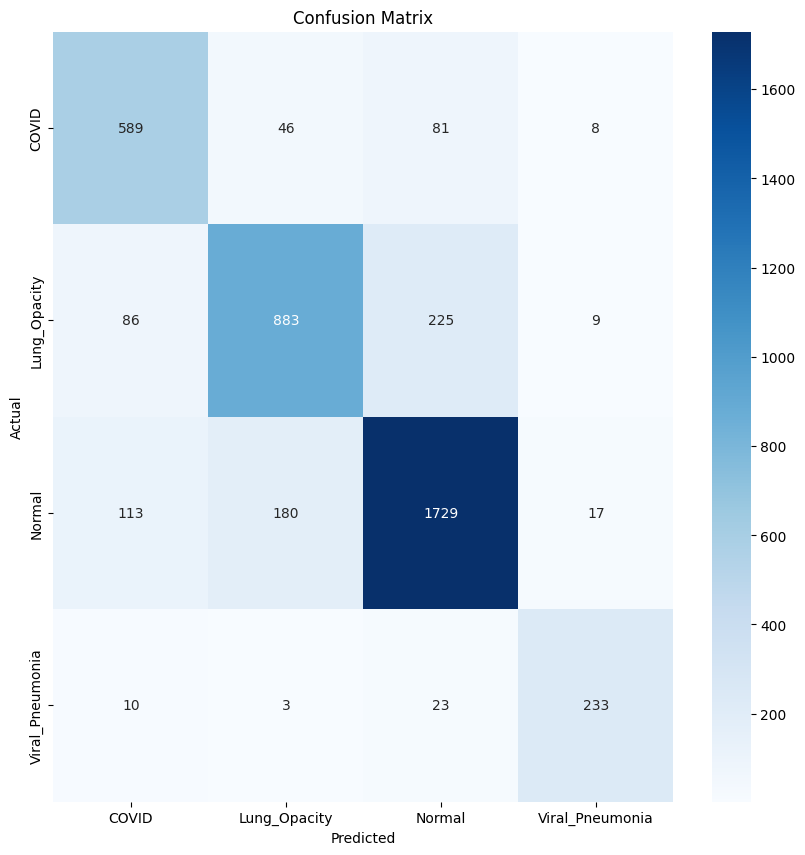

Accuracy: 0.8109
Precision: 0.8112
Recall: 0.8154


In [23]:
num_classes = 4
model_best_loaded = load_model(model, model_load_path, device).to(device)
accuracy, precision, recall, cm = evaluate_model(model_best_loaded, val_loader,device)